In [1]:
# pip install pytorch_pretrained_bert
!pip install transformers

     |████████████████████████████████| 890kB 2.7MB/s 
     |████████████████████████████████| 890kB 14.3MB/s 
     |████████████████████████████████| 3.0MB 18.6MB/s 
     |████████████████████████████████| 1.1MB 38.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=1602fd5fad49d98ef3a42d0ce3d612ea19d64798e51fd1059a6fafad3616cbeb
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import torch
# from pytorch_pretrained_bert import BertTokenizer, BertModel
from transformers import AutoModel, AutoTokenizer # Usei o modelo pre-treinado da neuralmind disponibilizado em pt
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib
import matplotlib.pyplot as plt
import nltk
from nltk import tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

##Funcoes

In [3]:
def content_sentences(body):
        sentences = tokenize.sent_tokenize(body, language='portuguese') #Tokens em pt
        return [c for c in sentences] # precisa de um tratamento melhor 

def tokenize_input(text):
        tokenized_text = tokenizer.tokenize(text)
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
        return torch.tensor([indexed_tokens])

def extract_embeddings(text):
        tokens_tensor = tokenize_input(text)
        hidden_states, pooled = model(tokens_tensor)[-2:]
        return pooled

##Classes

In [4]:
class ClusterFeatures(object):
    def __init__(self, features, algorithm='kmeans', pca_k=2):
        if pca_k:
            self.features = PCA(n_components=pca_k).fit_transform(features)
        else:
            self.features = features
        self.algorithm = algorithm
        self.pca_k = pca_k

    def __get_model(self, k):
        if self.algorithm == 'gmm':
            return GaussianMixture(n_components=k)
        if self.algorithm == 'affinity':
            return AffinityPropagation()
        return KMeans(n_clusters=k)

    def __get_centroids(self, model):
        if self.algorithm == 'gmm':
            return model.means_
        return model.cluster_centers_

    def __find_closest_args(self, centroids):
        centroid_min = 1e7
        cur_arg = -1
        args = {}
        used_idx = []
        for j, centroid in enumerate(centroids):
            for i, feature in enumerate(self.features):
                value = np.sum(np.abs(feature - centroid))
                if value < centroid_min and i not in used_idx:
                    cur_arg = i
                    centroid_min= value
            used_idx.append(cur_arg)
            args[j] = cur_arg
            centroid_min = 1e7
            cur_arg = -1
        return args

    def cluster(self, ratio=0.1):
        k = 1 if ratio * len(self.features) < 1 else int(len(self.features) * ratio)
        model = self.__get_model(k).fit(self.features)
        centroids = self.__get_centroids(model)
        cluster_args = self.__find_closest_args(centroids)
        sorted_values = sorted(cluster_args.values())
        return sorted_values

    def create_plots(self, k=4, plot_location='./cool_model.png', title = ''):
        if self.pca_k != 2:
            raise RuntimeError("Must be dimension of 2")

        model = self.__get_model(k)
        model.fit(self.features)
        y = model.predict(self.features)
        plt.title(title)
        plt.scatter(self.features[:, 0], self.features[:, 1], c=y, s=50, cmap='viridis')
        centers = model.cluster_centers_
        plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
        plt.savefig(plot_location)

##Aplicacao

In [5]:
body = '''
Números de uma pesquisa Datafolha publicada naquela quinta (28/05) foram divulgados no meio do debate.

O levantamento mostrava que a rejeição a Bolsonaro havia crescido ao longo do mês em meio às crises sanitária, política e econômica no Brasil.

A pesquisa feita nos dias 25 e 26 mostrava que 43% dos brasileiros consideravam o governo ruim ou péssimo, 33% ótimo ou bom, 22%, regular e 2% não sabiam.

Foram ouvidos 2.069 adultos, com margem de erro de dois pontos percentuais.

Ouvindo a live, um usuário comentou: "Já está claro que 33% não se convence, se vence".

Foi a senha para que caísse uma ficha para Moreira. "É verdade, a gente nunca fala dos 70%. Caramba, 70% no Brasil é gente para caramba. Os 70% não estão parecendo, estão com medo. Então eles nunca conseguem se perceber como 70%. Os 30% se acham 70% e os 70% se acham 30%."

E foi então que começou o movimento "Somos70porcento", uma hashtag que se espalhou nos dias seguintes em redes sociais e que se junta a outras iniciativas suprapartidárias que surgiram nos últimos dias em defesa da democracia e contra Bolsonaro.

O presidente e aliados têm feito discursos a favor de uma eventual ruptura institucional - e é principalmente em defesa da democracia, da Constituição e do Estado de Direito que esses grupos surgiram.

Além dos Somos70%, há o movimento Estamos Juntos, lançado no sábado (30) e com 258.686 assinaturas até o início da tarde desta terça (02).

O movimento publicou um manifesto no sábado em uma página inteira na edição impressa de jornais. "Somos mais de dois terços da população do Brasil e invocamos que partidos, seus líderes e candidatos agora deixem de lado projetos individuais de poder em favor de um projeto comum de país", diz o manifesto do grupo, que teve como signatários iniciais personalidades como Caetano Veloso, o youtuber e empresário Felipe Neto e o ex-presidente Fernando Henrique Cardoso, entre outros. Também teve apoio do ex-ministro da Saúde de Bolsonaro Luiz Henrique Mandetta.

"Esquerda, centro e direita unidos para defender a lei, a ordem, a política, a ética, as famílias, o voto, a ciência, a verdade, o respeito e a valorização da diversidade, a liberdade de imprensa, a importância da arte, a preservação do meio ambiente e a responsabilidade na economia."

O Estamos Juntos também criou diversos grupos de WhatsApp para diferentes Estados do Brasil, com link público no site do movimento - tática dos bolsonaristas na campanha de 2018. Até hoje, o WhatsApp é visto como uma rede onde apoiadores do presidente se articulam.

Outro movimento, chamado Basta!, foi lançado por advogados e juristas no domingo (31). O manifesto do grupo, com mais de 600 assinaturas quando foi divulgado, dizia que o país é "jogado ao precipício de uma crise política quando já imerso no abismo de uma pandemia que encontra no Brasil seu ambiente mais favorável, mercê de uma ação genocida do presidente da República". Hoje, já tem 30 mil assinaturas.

No dia seguinte à live de que participou, o economista Moreira tuitou "Somos os 70%". O tuíte teve 1,3 mil retuítes e 12,8 mil curtidas. Segundo o jornal O Estado de S. Paulo, a hashtag #Somos70PorCento chegou a ocupar o terceiro lugar entre os assuntos mais comentados do Twitter no fim de semana.

Moreira, um economista carioca de 44 anos, tem 380 mil inscritos em seu canal de YouTube, em que dá dicas de finanças e faz lives sobre economia e política, e 135 mil seguidores no Twitter.

"Estabeleceu-se um consenso até e talvez principalmente na esquerda, que com esses níveis de popularidade, não dá para fazer muita coisa. Então, nós temos que esperar a popularidade do Bolsonaro cair até que a gente tenha o poder de entrar com impeachment… E isso é para mim a maior de todas as derrotas porque esse esperar, na situação que a gente tá vivendo, é muito caro. É muito caro em número de vidas", disse ele na live de quinta (28).

"Como não é a hora? É mais do que a hora. Já passou da hora. A gente precisa desse choque de realidade porque a panela está fervendo. (…) O mundo inteiro está vendo e aqui a gente não tá vendo. Já tá muito quente, vai todo mundo morrer nessa panela."

No dia 30, a apresentadora Xuxa Meneghel aderiu ao movimento. "Somos70porcento", tuitou.

Marina Silva uniu os três movimentos suprapartidários em um só tuíte: "#Juntos #Somos70porcento #Basta! Que surjam outras canções em defesa da vida, da dignidade humana, do desenvolvimento sustentável e da democracia".

Esses movimentos surgidos nos últimos dias começam a tomar uma forma contra o governo de Bolsonaro, que vem causando e enfrentando crises.

No domingo, setores de torcidas organizadas que se denominam como antifascistas foram às ruas no Rio de Janeiro, São Paulo e outras cidades brasileiras, somando-se aos movimentos online da sociedade civil.

Um crítico dos movimentos é o ex-presidente Luiz Inácio Lula da Silva. Segundo a Folha de S.Paulo, ele criticou os manifestos em uma reunião do PT na segunda-feira. "Li os manifestos e acho que tem pouca coisa de interesse da classe trabalhadora. Não se fala em classe trabalhadora, nos direitos perdidos", disse o ex-presidente, segundo a Folha.
'''

In [6]:
initial_sentences = content_sentences(body)

# initial_sentences

In [7]:
model = AutoModel.from_pretrained('neuralmind/bert-large-portuguese-cased')

tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased')

In [8]:
vector_size = 1024

train_vec = np.zeros((len(initial_sentences), vector_size))

for i, t in tqdm(enumerate(initial_sentences)):
  # print("\ni:\n{0}\nt:\n{1}".format(i,t))

  train_vec[i] = extract_embeddings(t).data.numpy()  

# train_vec

46it [00:24,  1.91it/s]


In [9]:
ratio = 0.2

hidden_args = ClusterFeatures(train_vec).cluster(ratio)

if hidden_args[0] != 0:
            hidden_args.insert(0,0)

resultado = [initial_sentences[j] for j in hidden_args]

resultado

['\nNúmeros de uma pesquisa Datafolha publicada naquela quinta (28/05) foram divulgados no meio do debate.',
 'Ouvindo a live, um usuário comentou: "Já está claro que 33% não se convence, se vence".',
 'Caramba, 70% no Brasil é gente para caramba.',
 'O manifesto do grupo, com mais de 600 assinaturas quando foi divulgado, dizia que o país é "jogado ao precipício de uma crise política quando já imerso no abismo de uma pandemia que encontra no Brasil seu ambiente mais favorável, mercê de uma ação genocida do presidente da República".',
 'Hoje, já tem 30 mil assinaturas.',
 '"Estabeleceu-se um consenso até e talvez principalmente na esquerda, que com esses níveis de popularidade, não dá para fazer muita coisa.',
 'É mais do que a hora.',
 'A gente precisa desse choque de realidade porque a panela está fervendo.',
 '(…) O mundo inteiro está vendo e aqui a gente não tá vendo.',
 'Segundo a Folha de S.Paulo, ele criticou os manifestos em uma reunião do PT na segunda-feira.']

In [10]:
pprint(resultado)

Pretty printing has been turned OFF


In [11]:
from pprint import pprint
pprint(body)

('\n'
 'Números de uma pesquisa Datafolha publicada naquela quinta (28/05) foram '
 'divulgados no meio do debate.\n'
 '\n'
 'O levantamento mostrava que a rejeição a Bolsonaro havia crescido ao longo '
 'do mês em meio às crises sanitária, política e econômica no Brasil.\n'
 '\n'
 'A pesquisa feita nos dias 25 e 26 mostrava que 43% dos brasileiros '
 'consideravam o governo ruim ou péssimo, 33% ótimo ou bom, 22%, regular e 2% '
 'não sabiam.\n'
 '\n'
 'Foram ouvidos 2.069 adultos, com margem de erro de dois pontos percentuais.\n'
 '\n'
 'Ouvindo a live, um usuário comentou: "Já está claro que 33% não se convence, '
 'se vence".\n'
 '\n'
 'Foi a senha para que caísse uma ficha para Moreira. "É verdade, a gente '
 'nunca fala dos 70%. Caramba, 70% no Brasil é gente para caramba. Os 70% não '
 'estão parecendo, estão com medo. Então eles nunca conseguem se perceber como '
 '70%. Os 30% se acham 70% e os 70% se acham 30%."\n'
 '\n'
 'E foi então que começou o movimento "Somos70porcento", 

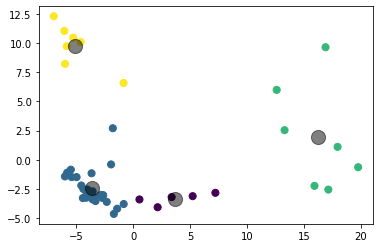

In [12]:
ClusterFeatures(train_vec).create_plots()